In [136]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso 


import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

In [41]:
media_wise = pd.read_excel("train.xlsx", sheet_name='data')

In [42]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [43]:
media_wise

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,InvTVReg12,Total12,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,7155663.63,11834254.13,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,8348274.24,13996532.16,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,8348274.24,11466294.66,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,8348274.24,10764632.16,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,8477038.25,10984967.91,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,2024,52,2024-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
media_wise.dtypes

year                       int64
week                       int64
weekB             datetime64[ns]
SalesRub                 float64
Sales                    float64
                       ...      
InvDigital13             float64
InvSponsorTV13           float64
InvOON13                 float64
InvRadio13               float64
Total13                  float64
Length: 135, dtype: object

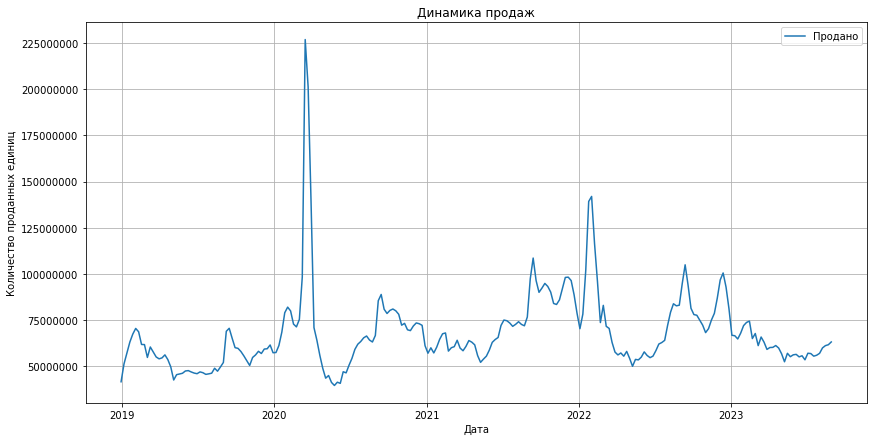

In [45]:
def year_week_to_date(year, week):
    first_day_of_year = datetime.date(year, 1, 1)
    if first_day_of_year.weekday() <= 3:
        first_day_of_year -= datetime.timedelta(days=first_day_of_year.weekday())  
    else:
        first_day_of_year += datetime.timedelta(days=7-first_day_of_year.weekday())
    week_start = first_day_of_year + datetime.timedelta(weeks=week-1)
    return week_start


media_wise['Дата'] = media_wise.apply(lambda row: year_week_to_date(row['year'], row['week']), axis=1)
media_wise = media_wise.sort_values('Дата')


plt.figure(figsize=(14, 7))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(media_wise['Дата'], media_wise['SalesRub'], label='Продано')
plt.title('Динамика продаж')
plt.xlabel('Дата')
plt.ylabel('Количество проданных единиц')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
def plot_rolling(n,year = False, plot_intervals=False, scale=1.96, plot_anomalies=False,acc=[],DATE=media_wise.Дата):
    rolling_mean = acc.rolling(window=n).mean()
    plt.figure(figsize=(16,8))
    plt.grid(True)
    if year:
        plt.plot(DATE,acc[:365].values,label = 'Данные')
        plt.plot(rolling_mean[:365].values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    else:
        plt.plot(DATE,acc.values,label = 'Данные')
        plt.plot(DATE,rolling_mean.values, label = 'Скользящее среднее с шагом n = '+str(n),c = 'red')
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(acc[n:], rolling_mean[n:])
        deviation = np.std(acc[n:] - rolling_mean[n:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = []
            indexes = []
            for i in range(len(acc)):
                if acc[i]<lower_bond[i] or acc[i]>upper_bond[i]:
                    indexes.append(i)
                    anomalies.append(acc[i])
            plt.plot(indexes,anomalies, "ro", markersize=10)
        
    plt.legend()
    plt.show()

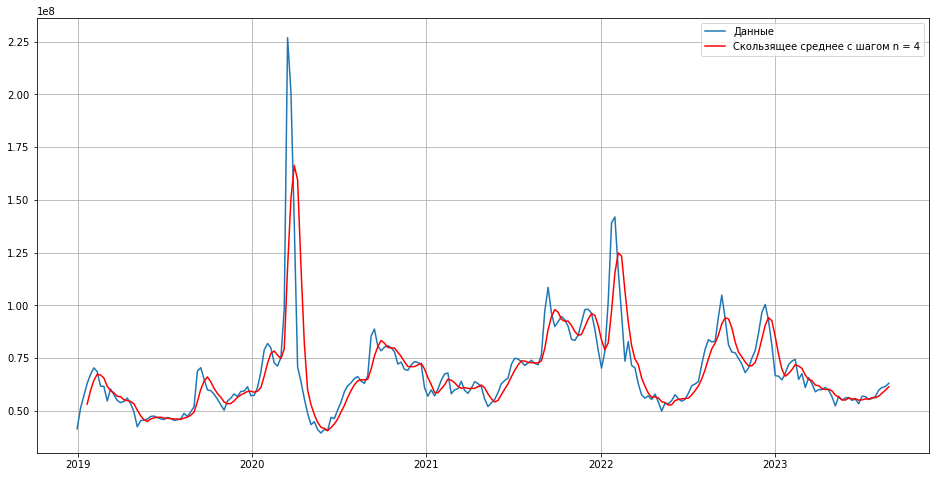

In [47]:
plot_rolling(4,acc=media_wise.SalesRub)

ничего не дает

In [48]:
media_wise 

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,Total12,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,11834254.13,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,13996532.16,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,11466294.66,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,10764632.16,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,10984967.91,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2024,48,2024-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-25
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-02
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-09
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-16



На графике изображена динамика продаж продукта или услуги с течением времени. Вот несколько наблюдений:

Наблюдаются колебания продаж на протяжении всего представленного периода. Это может быть связано с сезонными факторами, изменениями в спросе или влиянием рекламных кампаний.
Есть два выраженных пика продаж: один в 2020 году и один в 2021 году. Пик в 2020 году связан с короной.
После пика в 2020 году наблюдается резкое падение, что может указывать на исчерпание спроса или окончание акции.
В целом, кажется, что в 2022 году продажи стали более стабильными и менее подверженными резким колебаниям, по сравнению с предыдущими годами.
К концу 2022 года и началу 2023 года наблюдается устойчивый тренд на увеличение продаж, который может свидетельствовать о восстановлении спроса, улучшении маркетинговых усилий или позитивном влиянии внешних факторов на рынок.

ADF Statistic (after differencing): -12.445469
p-value (after differencing): 0.000000
Critical Values (after differencing):
	1%: -3.458
	5%: -2.874
	10%: -2.573


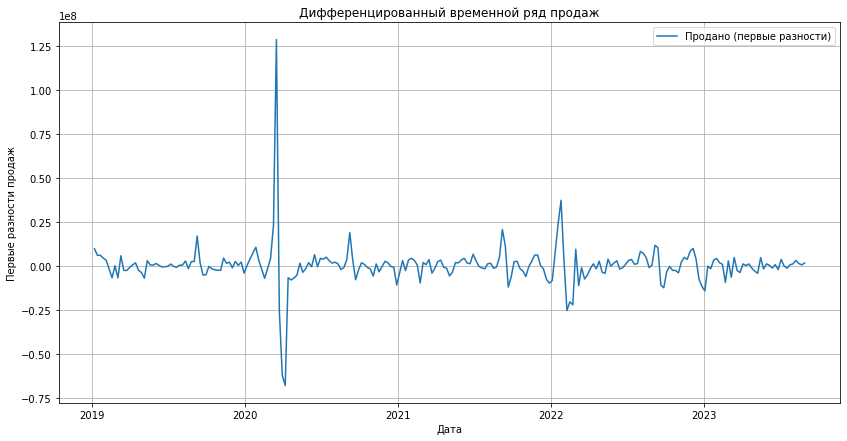

In [49]:
media_wise['Продано_diff'] = media_wise['SalesRub'].diff()

adf_test_result_diff = adfuller(media_wise ['Продано_diff'].dropna())

print("ADF Statistic (after differencing): %f" % adf_test_result_diff[0])
print("p-value (after differencing): %f" % adf_test_result_diff[1])
print("Critical Values (after differencing):")
for key, value in adf_test_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))


plt.figure(figsize=(14, 7))
plt.plot(media_wise['Дата'][1:], media_wise['Продано_diff'][1:], label='Продано (первые разности)')
plt.title('Дифференцированный временной ряд продаж')
plt.xlabel('Дата')
plt.ylabel('Первые разности продаж')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
weeks_to_replace = [12, 13]

filtered_data = media_wise[(media_wise['week'].isin(weeks_to_replace)) & (media_wise['year'] != 2020)]
average_sales = filtered_data.groupby('week')['SalesRub'].mean().to_dict()
media_wise.loc[(media_wise['year'] == 2020) & (media_wise['week'].isin(weeks_to_replace)), 'SalesRub'] = media_wise.loc[(media_wise['year'] == 2020) & (media_wise['week'].isin(weeks_to_replace)), 'week'].map(average_sales)
media_wise[(media_wise['year'] == 2020) & (media_wise['week'].isin(weeks_to_replace))]


,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата,Продано_diff
63,2020,12,2020-03-16,60828150.82,580588.05,0.00,0.00,0.00,0.00,0.00,...,271.89,20.38,7655730.27,0.00,0.00,0.00,0.00,7655730.27,2020-03-16,128593467.50
64,2020,13,2020-03-23,57498727.06,490829.85,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,,0.00,0.00,0.00,0.00,NaN,2020-03-23,-25641497.37


In [51]:
def adf_test(series, title=''):
    # Очистка данных от бесконечностей и NaN значений
    series_clean = series.replace([np.inf, -np.inf], np.nan).dropna()
    
    print(f'ADF Test: {title}')
    result = adfuller(series_clean, autolag='AIC')  # ADF test
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # Выводим результаты теста ADF
    
    if result[1] <= 0.05:
        print("Стационарный ряд на уровне 5%")
    else:
        print("Нестационарный ряд на уровне 5%")
    print("\n")

    
adf_test(media_wise['SalesRub'].dropna(), 'Продажи')

ADF Test: Продажи
ADF test statistic      -4.81
p-value                  0.00
# lags used              0.00
# observations         243.00
critical value (1%)     -3.46
critical value (5%)     -2.87
critical value (10%)    -2.57
Стационарный ряд на уровне 5%




результаты ADF теста показывают, что временной ряд продаж стационарен на уровне значимости 5%. Это значит, что среднее значение и дисперсия ряда не меняются со временем, и он не требует дифференцирования для достижения стационарности.

In [52]:
media_wise

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата,Продано_diff
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31,NaN
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07,9686718.89
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14,5905062.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21,5913642.03
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28,4295897.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2024,48,2024-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11-25,NaN
309,2024,49,2024-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-02,NaN
310,2024,50,2024-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-09,NaN
311,2024,51,2024-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-16,NaN


In [53]:
for column in ['Total1', 'Total2', 'Total3', 'Total4', 'Total5', 'Total6', 'Total7',
               'Total8', 'Total9', 'Total10', 'Total11', 'Total12', 'Total13']:
    media_wise[column].fillna(0, inplace=True)


media_wise[['Total1', 'Total2', 'Total3', 'Total4', 'Total5', 'Total6', 'Total7',
            'Total8', 'Total9', 'Total10', 'Total11', 'Total12', 'Total13']].isnull().sum(), 'Продано_diff' in media_wise.columns

(Total1     0
 Total2     0
 Total3     0
 Total4     0
 Total5     0
 Total6     0
 Total7     0
 Total8     0
 Total9     0
 Total10    0
 Total11    0
 Total12    0
 Total13    0
 dtype: int64,
 True)

In [54]:
non_numeric_columns = ['InvTV', 'InvTV2', 'InvTVReg3', 'TRP4', 'TRP6', 'InvTV6', 'InvTV7', 'InvTV9', 'InvTV12', 'InvTV13']

In [55]:
for column in non_numeric_columns:
    media_wise[column] = pd.to_numeric(media_wise[column], errors='coerce')

In [56]:
non_numeric_columns = media_wise.select_dtypes(exclude=[np.number]).columns.tolist()

print(non_numeric_columns)

['weekB', 'Дата']


In [57]:
nan_columns = ['InvTV', 'InvTV2', 'InvTVReg3', 'TRP4', 'TRP6', 'InvTV6', 'InvTV7', 'InvTV9', 'InvTV12', 'InvTV13']

In [58]:
media_wise[nan_columns] = media_wise[nan_columns].fillna(0)

In [59]:
media_wise_filtered = media_wise[(media_wise['year'] < 2023) | ((media_wise['year'] == 2023) & (media_wise['week'] < 36))]

In [60]:
media_wise_filtered

,year,week,weekB,SalesRub,Sales,SalesRubMonth,R1,R2,R3,R4,...,TRP13,CoverageTV13,InvTV13,InvDigital13,InvSponsorTV13,InvOON13,InvRadio13,Total13,Дата,Продано_diff
0,2019,1,2018-12-31,41535567.34,114621.15,0.00,0.00,0.00,0.00,0.00,...,207.90,15.36,9085528.01,0.00,0.00,0.00,0.00,9085528.01,2018-12-31,NaN
1,2019,2,2019-01-07,51222286.23,141523.20,0.00,0.00,0.00,0.00,0.00,...,317.47,25.53,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-07,9686718.89
2,2019,3,2019-01-14,57127348.91,157926.30,0.00,0.00,0.00,0.00,0.00,...,192.82,13.91,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-14,5905062.68
3,2019,4,2019-01-21,63040990.94,173746.65,0.00,0.00,0.00,0.00,0.00,...,138.37,8.05,10599782.68,0.00,0.00,0.00,0.00,10599782.68,2019-01-21,5913642.03
4,2019,5,2019-01-28,67336888.87,185551.80,0.00,0.00,0.00,0.00,0.00,...,286.98,24.22,12893092.41,0.00,0.00,0.00,0.00,12893092.41,2019-01-28,4295897.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2023,31,2023-07-31,56931505.06,110088.30,415482902.57,243689995.89,122713435.51,29294571.05,412081.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-07-31,1028054.09
240,2023,32,2023-08-07,59881512.89,115345.65,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-07,2950007.83
241,2023,33,2023-08-14,61112178.46,117761.70,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-14,1230665.56
242,2023,34,2023-08-21,61594925.03,118356.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2023-08-21,482746.57


In [114]:
media_wise_filtered.dtypes

year                     int64
week                     int64
weekB           datetime64[ns]
SalesRub               float64
Sales                  float64
                     ...      
InvOON13               float64
InvRadio13             float64
Total13                float64
Дата                    object
Продано_diff           float64
Length: 137, dtype: object

## ПОСТРОИМ МАТРИЦУ КОРРЕЛЯЦИЙ

In [115]:
correlation_matrix = media_wise_filtered.corr()
correlated_features = correlation_matrix.index[correlation_matrix["SalesRub"] > 0.2].tolist()
correlated_features.remove('SalesRub') if 'SalesRub' in correlated_features else correlated_features


correlated_features

['year',
 'Sales',
 'SalesRubMonth',
 'R1',
 'R2',
 'R3',
 'R4',
 'R5',
 'R6',
 'Distribution',
 'Morbidity',
 'InvDigiral',
 'Wordstat',
 'InvDigital1',
 'InvSponsorTV1',
 'InvDigital5',
 'Total5',
 'TRP6',
 'CoverageTV6',
 'InvTV6',
 'InvDigital6',
 'Total6',
 'InvTV7',
 'InvOON7',
 'Total7',
 'TRP9',
 'CoverageTV9',
 'InvTV9',
 'InvTVReg9',
 'Total9',
 'InvDigital10',
 'Total10',
 'InvDigital11',
 'TRP12',
 'CoverageTV12',
 'InvTV12',
 'Total12',
 'TRP13',
 'CoverageTV13',
 'InvDigital13',
 'InvRadio13',
 'Total13']

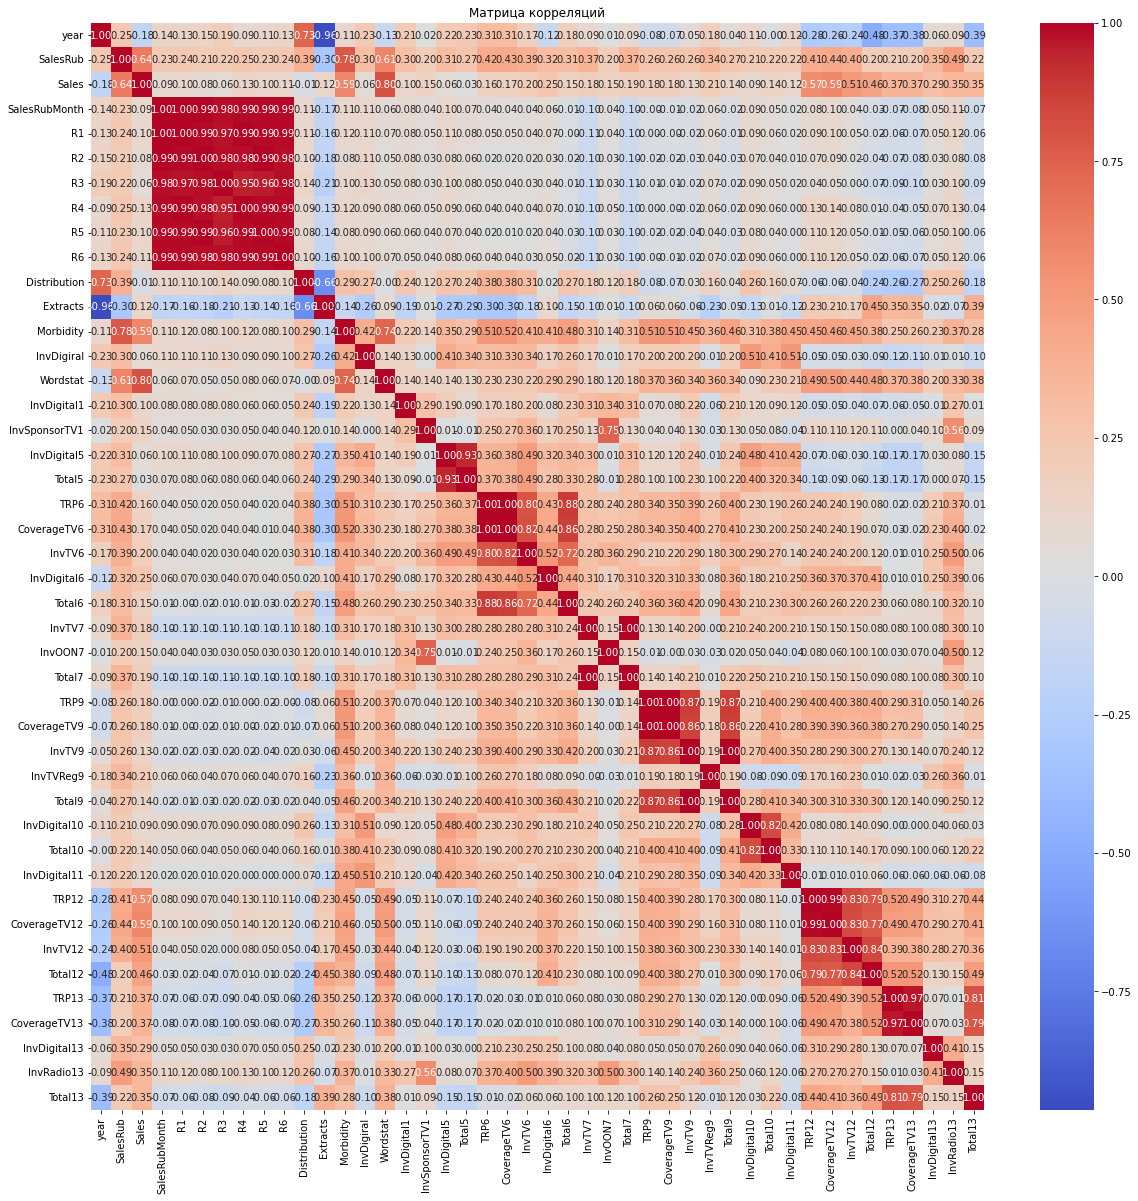

In [116]:
correlation_matrix = media_wise_filtered.corr()
features_high_correlation = correlation_matrix.index[abs(correlation_matrix["SalesRub"]) > 0.2].tolist()
selected_correlation_matrix = correlation_matrix.loc[features_high_correlation, features_high_correlation]

plt.figure(figsize=(20, 20))
sns.heatmap(selected_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Матрица корреляций')
plt.show()

In [117]:
import pandas as pd

# Предположим, что media_wise_filtered - это ваш исходный DataFrame
correlation_matrix = media_wise_filtered.corr()

# Отбор признаков с корреляцией больше 0.1 по модулю с SalesRub
features_high_correlation = correlation_matrix.index[abs(correlation_matrix["SalesRub"]) > 0.1].tolist()

# Всегда включаем 'SalesRub' и другие важные столбцы в список
mandatory_columns = ['SalesRub', 'year', 'week', 'weekB']  # Список обязательных столбцов
features_high_correlation.extend(mandatory_columns)  # Добавляем обязательные столбцы
features_high_correlation = list(set(features_high_correlation))  # Удаляем возможные дубликаты

# Создание нового DataFrame только с выбранными признаками
media_wise_selected = media_wise_filtered[features_high_correlation]

# Вывод информации о новом DataFrame
print(media_wise_selected.info())
print("Новый датасет успешно создан и содержит только отобранные признаки с корреляцией > 0.1.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 71 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              244 non-null    int64         
 1   Morbidity         244 non-null    float64       
 2   InvTVReg5         244 non-null    float64       
 3   SalesRub          244 non-null    float64       
 4   InvTVReg3         244 non-null    float64       
 5   Total3            244 non-null    float64       
 6   InvTV12           244 non-null    float64       
 7   Wordstat          244 non-null    float64       
 8   Distribution      244 non-null    float64       
 9   InvDigiral        244 non-null    float64       
 10  TRP8              244 non-null    float64       
 11  InvOON7           244 non-null    float64       
 12  InvTV             244 non-null    float64       
 13  InvDigital1       244 non-null    float64       
 14  TRP12             244 non-

In [118]:
columns_to_drop = ['Sales', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'Продано_diff']
media_wise_selected.drop(columns=columns_to_drop, errors='ignore', inplace = True)

C:\Users\Юля\AppData\Local\Temp\ipykernel_5288\1998721414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  media_wise_selected.drop(columns=columns_to_drop, errors='ignore', inplace = True)


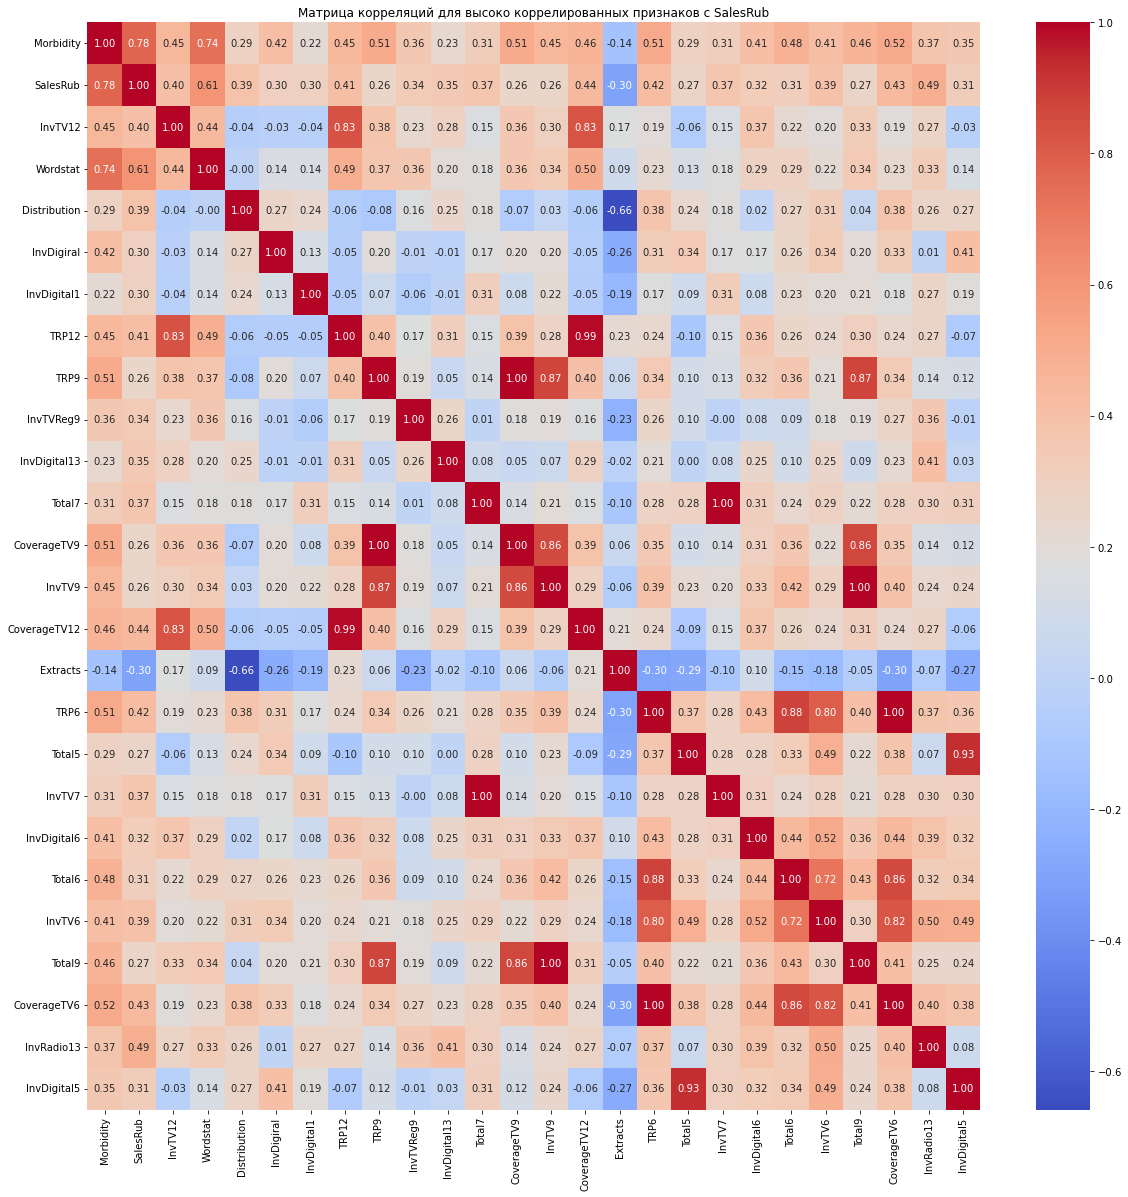

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Пересчитываем корреляционную матрицу для уже отобранных признаков
correlation_matrix = media_wise_selected.corr()

# Создаем булев индекс для признаков, которые имеют корреляцию больше 0.3 по модулю с SalesRub
high_corr_index = correlation_matrix["SalesRub"].abs() > 0.25

# Фильтруем индексы, удовлетворяющие условию выше
features_high_correlation = correlation_matrix.index[high_corr_index].tolist()

# Создаем корреляционную матрицу только для отобранных признаков
selected_correlation_matrix = correlation_matrix.loc[features_high_correlation, features_high_correlation]

# Визуализация корреляционной матрицы
plt.figure(figsize=(20, 20))
sns.heatmap(selected_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Матрица корреляций для высоко коррелированных признаков с SalesRub')
plt.show()


### Отбор X и Y

In [124]:
columns_to_drop = ['SalesRub', 'year', 'week', 'weekB', 'Sales', 'SalesRubMonth', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'Дата','Продано_diff']
X = media_wise_selected.drop(columns=columns_to_drop, errors='ignore')
Y = media_wise_selected['SalesRub'].dropna()

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [126]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [127]:
def timeseries_train_test_split(X, Y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = Y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = Y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [128]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, Y, test_size=0.3)

## Лассо

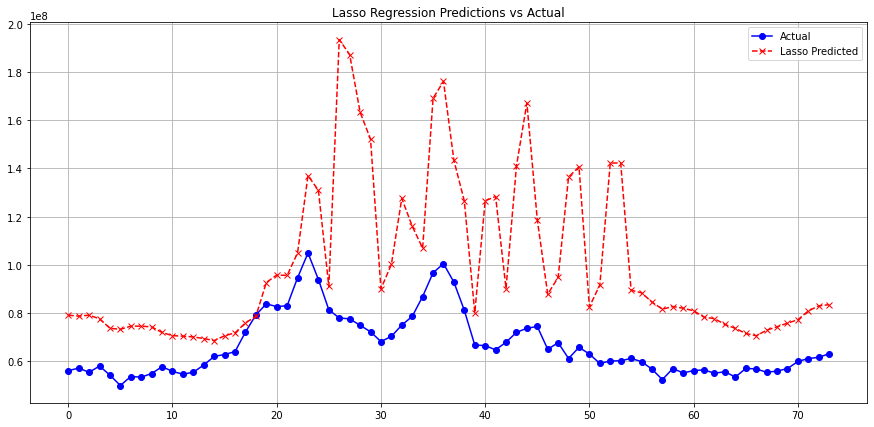

Mean Absolute Percentage Error (MAPE): 0.49%


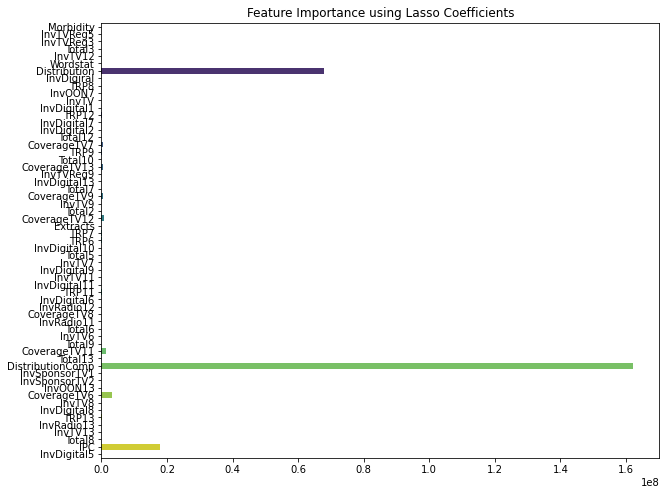

In [137]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Обучение Lasso регрессии
tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv, alphas=np.logspace(-6, 2, 100), max_iter=100000)
lasso.fit(X_train, y_train)

# Предсказание значений на тестовом наборе
y_pred_lasso = lasso.predict(X_test)

# 2. Визуализация результатов предсказания
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_lasso, label='Lasso Predicted', color='red', linestyle='--', marker='x')
plt.title('Lasso Regression Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Расчет MAPE
mape = mean_absolute_percentage_error(y_test, y_pred_lasso)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# 3. Отображение важности признаков
lasso_coefs = np.abs(lasso.coef_)
features = X_train.columns

plt.figure(figsize=(10, 8))
sns.barplot(y=features, x=lasso_coefs, palette='viridis')
plt.title('Feature Importance using Lasso Coefficients')
plt.show()



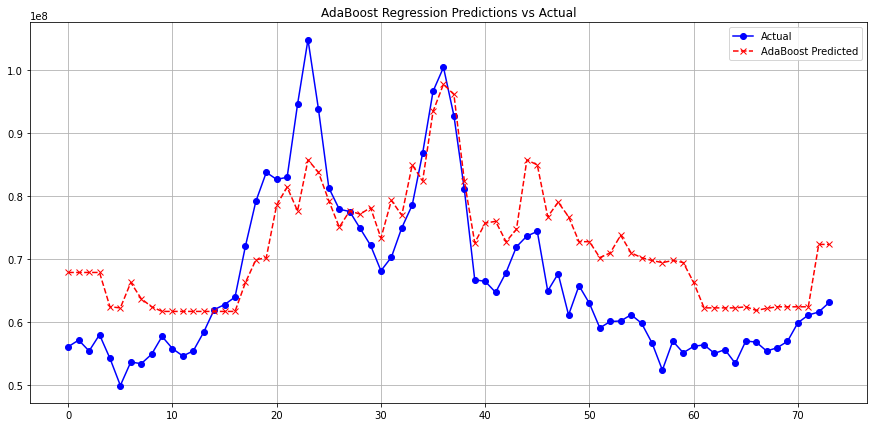

Train R^2: 0.903
Test R^2: 0.519
Train MAPE: 0.08%
Test MAPE: 0.12%
Test MAE: 7767401.02
Test MSE: 79700309953609.16


In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Подготовка данных: масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение AdaBoostRegressor
gbr = AdaBoostRegressor(n_estimators=100, random_state=0)
gbr.fit(X_train_scaled, y_train)

# Предсказание значений на тестовом наборе
y_pred_train = gbr.predict(X_train_scaled)
y_pred_test = gbr.predict(X_test_scaled)

# Визуализация результатов предсказания
plt.figure(figsize=(15, 7))
plt.plot(y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_test, label='AdaBoost Predicted', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Regression Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()

# Расчет метрик
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Train R^2: {r2_train:.3f}')
print(f'Test R^2: {r2_test:.3f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
print(f'Test MAE: {mae_test:.2f}')
print(f'Test MSE: {mse_test:.2f}')


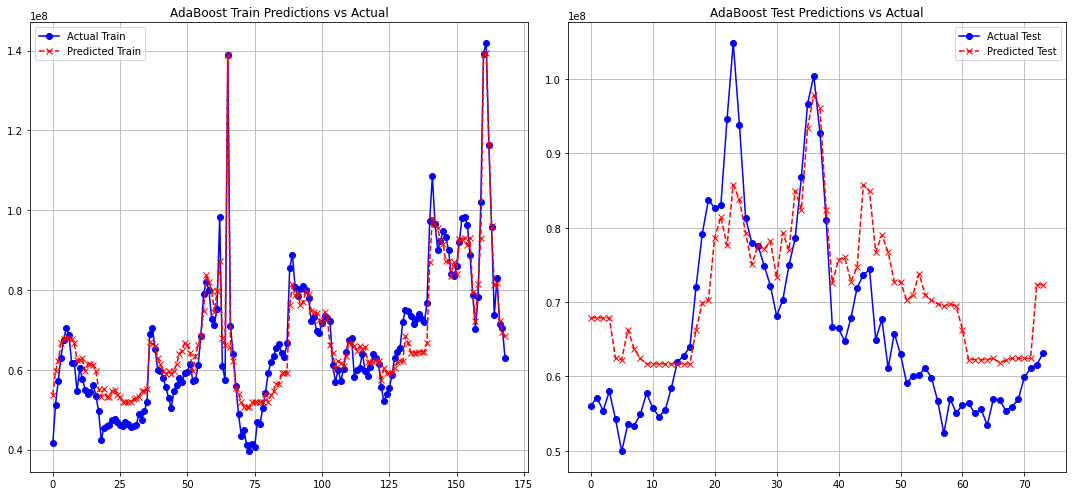

Train R^2: 0.903
Test R^2: 0.519
Train MAPE: 0.08%
Test MAPE: 0.12%
Test MAE: 7767401.02
Test MSE: 79700309953609.16


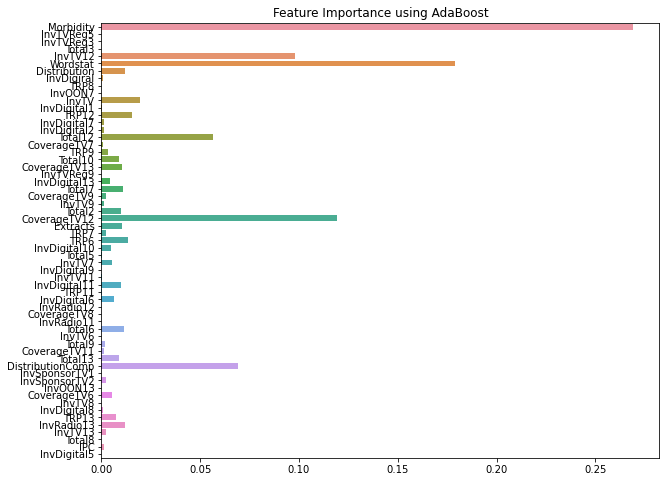

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Подготовка данных: масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение AdaBoostRegressor
gbr = AdaBoostRegressor(n_estimators=100, random_state=0)
gbr.fit(X_train_scaled, y_train)

# Предсказание значений на тренировочном и тестовом наборах
y_pred_train = gbr.predict(X_train_scaled)
y_pred_test = gbr.predict(X_test_scaled)

# Визуализация результатов предсказания для обучающего набора
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)  # Первый подграфик для тренировочных данных
plt.plot(y_train.values, label='Actual Train', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_train, label='Predicted Train', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Train Predictions vs Actual')
plt.legend()
plt.grid(True)

# Визуализация результатов предсказания для тестового набора
plt.subplot(1, 2, 2)  # Второй подграфик для тестовых данных
plt.plot(y_test.values, label='Actual Test', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_test, label='Predicted Test', color='red', linestyle='--', marker='x')
plt.title('AdaBoost Test Predictions vs Actual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод метрик
print(f'Train R^2: {r2_train:.3f}')
print(f'Test R^2: {r2_test:.3f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')
print(f'Test MAE: {mae_test:.2f}')
print(f'Test MSE: {mse_test:.2f}')

# Вывод важности признаков
feature_importances = gbr.feature_importances_
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importance using AdaBoost')
plt.show()



In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Определение параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'loss': ['linear', 'square', 'exponential']
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    AdaBoostRegressor(random_state=0), 
    param_grid, 
    cv=3,  # Количество фолдов в кросс-валидации
    scoring='neg_mean_absolute_percentage_error',  # Минимизация MAPE
    n_jobs=-1
)

# Запуск поиска
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры и лучший скор (преобразование скора в положительное значение)
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Преобразование, т.к. используется neg_mean_absolute_percentage_error

# Обучение AdaBoostRegressor с лучшими параметрами
best_gbr = AdaBoostRegressor(**best_params, random_state=0)
best_gbr.fit(X_train_scaled, y_train)

# Предсказание значений и расчет метрик для лучшей модели
y_pred_train_best = best_gbr.predict(X_train_scaled)
y_pred_test_best = best_gbr.predict(X_test_scaled)
r2_train_best = r2_score(y_train, y_pred_train_best)
r2_test_best = r2_score(y_test, y_pred_test_best)
mape_train_best = mean_absolute_percentage_error(y_train, y_pred_train_best)
mape_test_best = mean_absolute_percentage_error(y_test, y_pred_test_best)

print(f'Лучшие параметры: {best_params}')
print(f'Лучший MAPE: {best_score:.2f}%')
print(f'Best Train R^2: {r2_train_best:.3f}')
print(f'Best Test R^2: {r2_test_best:.3f}')
print(f'Best Train MAPE: {mape_train_best:.2f}%')
print(f'Best Test MAPE: {mape_test_best:.2f}%')


Лучшие параметры: {'learning_rate': 1, 'loss': 'square', 'n_estimators': 300}
Лучший MAPE: 0.19%
Best Train R^2: 0.878
Best Test R^2: 0.530
Best Train MAPE: 0.09%
Best Test MAPE: 0.12%


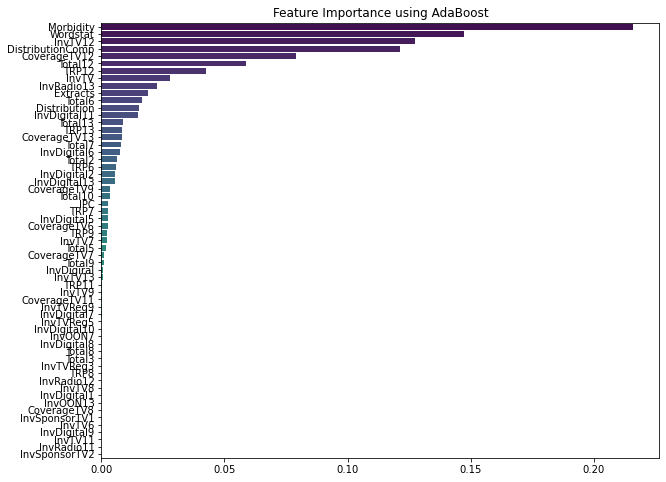

In [140]:
# Обучение лучшей модели AdaBoostRegressor
best_gbr = grid_search.best_estimator_
best_gbr.fit(X_train_scaled, y_train)

# Получение важности признаков
feature_importances = best_gbr.feature_importances_

# Визуализация важности признаков
features = X_train.columns
indices = np.argsort(feature_importances)[::-1]  # Индексы в порядке убывания важности

plt.figure(figsize=(10, 8))
sns.barplot(y=features[indices], x=feature_importances[indices], palette='viridis')
plt.title('Feature Importance using AdaBoost')
plt.show()

# ЧЕРНОВИКИ

In [ ]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso,normas = True)

In [97]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [104]:
amount0 = media_wise_selected.SalesRub
tsplot(amount0,80)

AttributeError: 'DataFrame' object has no attribute 'SalesRub'

Временной ряд: График показывает данные временного ряда с резкими пиками, которые могут соответствовать необычным событиям (например эпидемии COVID), влияющим на продажи.

Стационарность: Временной ряд был проанализирован на стационарность с использованием теста Дики-Фуллера. Полученное p-значение составляет 0.00069, что значительно ниже обычно используемого порога 0.05, следовательно, можно утверждать, что временной ряд стационарен. Это означает, что его статистические свойства, такие как среднее и дисперсия, не изменяются со временем.

Автокорреляция: График автокорреляции показывает, что существует высокая корреляция между последовательными значениями временного ряда, особенно на первых лагах. Это указывает на то, что предыдущие продажи могут быть хорошими предикторами для будущих продаж. Однако корреляция уменьшается по мере увеличения лага, что является нормальным для большинства временных рядов.

Частичная автокорреляция: График частичной автокорреляции показывает значимые корреляции на первом лаге и становится близким к нулю на последующих лагах. Это может указывать на то, что модель авторегрессии первого порядка (AR(1)) может быть подходящей для моделирования данных временного ряда.

p=1
q = 9
d = 1
s = 5
P = 1
Q = 1
D = 1


import pandas as pd
from tqdm.notebook import tqdm
import statsmodels.api as sm
from itertools import product

# Example data definition and model function
# Ensure your data is loaded into `data` here if it's not part of the function arguments

def optimizeSARIMA(parameters_list, d, D, data):
    """
    Return dataframe with parameters and corresponding AIC for the top 20 models
    
    parameters_list - list with (p, q, P, Q, s) tuples
    d - integration order in ARIMA model
    D - seasonal integration order
    data - the time series data
    """
    
    results = []
    best_aic = float("inf")
    best_model = None
    best_param = None

    for param in tqdm(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], param[4])).fit(disp=-1)
        except Exception as e:
            print(f"Failed to fit model for parameters: {param}. Error: {str(e)}")
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, aic])

    result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table.head(20)  # Return only the top 20 results

# Setup for parameters and function call
ps = range(2, 5)
d = 1
qs = range(0, 10)
Ps = range(0, 40)
D = 1
Qs = range(0, 2)
s_values = range(1, 40)  # Assuming you don't want to include 0 in your seasonal period

parameters = product(ps, qs, Ps, Qs, s_values)
parameters_list = list(parameters)

# You would call the function as follows:
data = media_wise_filtered.SalesRub  # Ensure your time series data is loaded correctly
result_table = optimizeSARIMA(parameters_list, d, D, data)
result_table

In [99]:
columns_to_drop = ['SalesRub', 'year', 'week', 'weekB', 'Sales', 'SalesRubMonth', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'Дата','Продано_diff']
X = media_wise_filtered.drop(columns=columns_to_drop, errors='ignore')
Y = media_wise_filtered['SalesRub'].dropna()

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [77]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [78]:
def timeseries_train_test_split(X, Y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = Y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = Y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [79]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, Y, test_size=0.3)

In [84]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit

# Assuming tscv is defined, if not, define it as follows:
tscv = TimeSeriesSplit(n_splits=5)

# Define alphas but start from a small positive number
ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.01, 100, 100))
ridge.fit(X_train, y_train)




C:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.26784e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
C:\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: 

RidgeCV(alphas=array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01, 2.122e+01, 2.223e+01, 2.324e+01,
       2.425e+01, 2.526e+01, 2.627e+01, 2.728e+01, 2.829e+01, 2.930e+01,
       3.031e+01, 3.132e+01, 3.233e+0...
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [85]:
import matplotlib.pyplot as plt

def plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
    Plot model results including training and test sets predictions.
    """
    prediction = model.predict(X_train)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0)
    plt.legend(loc="best")
    plt.title("Train data")
    plt.grid(True)

    prediction_test = model.predict(X_test)
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_test, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.legend(loc="best")
    plt.title("Test data")
    plt.grid(True)

def plotCoefficients(model):
    """
    Plots sorted coefficient values of the model.
    """
    coefs = pd.Series(model.coef_, index = X_train.columns)
    coefs.sort_values().plot(kind = "barh", figsize = (9, 7))
    plt.title("Coefficients in the Ridge Model")
    plt.xlabel("Coefficient value")
    plt.ylabel("Features")
    plt.show()


In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Создание пайплайна с предобработкой и RidgeCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(cv=tscv, alphas=np.linspace(0.01, 100, 100)))
])
pipeline.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 RidgeCV(alphas=array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01, 2.122e+01, 2.223e+01, 2.324e+01,
       2.425e+01, 2.526e+01, 2.627e+01, 2.728...
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02]),
                         cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)))])

In [88]:
from sklearn.decomposition import PCA

# Комбинирование PCA и RidgeCV в пайплайне
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),  # Выбираем первые 10 компонент
    ('ridge', RidgeCV(cv=tscv, alphas=np.linspace(0.01, 100, 100)))
])
pca_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('ridge',
                 RidgeCV(alphas=array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01, 2.122e+01, 2.223e+01, 2.324e+01,
       2.425e...
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02]),
                         cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)))])

In [89]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=tscv, alphas=np.linspace(0.01, 100, 100)).fit(X_train, y_train)


C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.076e+12, tolerance: 1.805e+11
  model = cd_fast.enet_coordinate_descent(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.966e+12, tolerance: 1.805e+11
  model = cd_fast.enet_coordinate_descent(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.896e+12, tolerance: 1.805e+11
  model = cd_fast.enet_coo

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Определение стратегии кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)

# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация признаков
    ('ridge', RidgeCV(cv=tscv, alphas=np.linspace(0.01, 100, 100)))  # Модель RidgeCV
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Предсказания модели
y_pred = pipeline.predict(X_test)


In [91]:
from sklearn.decomposition import PCA

# Создание пайплайна с PCA
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Стандартизация признаков
    ('pca', PCA(n_components=10)),  # Применение PCA
    ('ridge', RidgeCV(cv=tscv, alphas=np.linspace(0.01, 100, 100)))  # Модель RidgeCV
])

# Обучение модели
pca_pipeline.fit(X_train, y_train)

# Предсказания модели
y_pred_pca = pca_pipeline.predict(X_test)


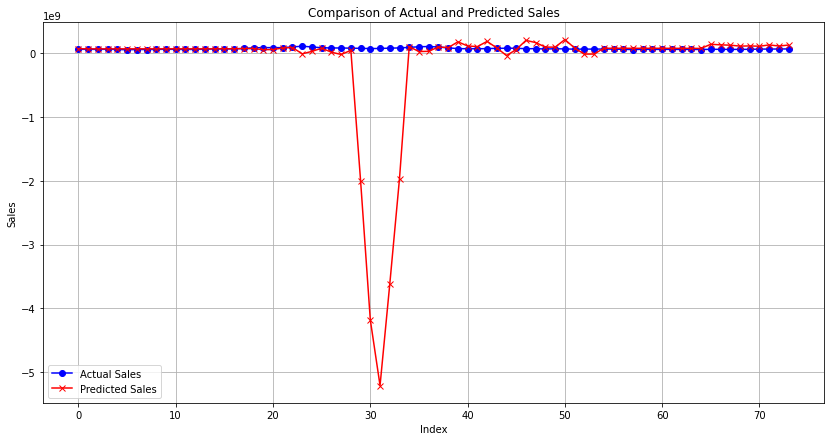

Mean Squared Error: 9.218357444400433e+17
R-squared: -5565.211674843082


In [95]:
import matplotlib.pyplot as plt

# Предсказание значений на тестовом наборе
y_pred_pca = pca_pipeline.predict(X_test)

# Визуализация фактических значений и предсказаний
plt.figure(figsize=(14, 7))
plt.plot(y_test.reset_index(drop=True), label='Actual Sales', color='blue', marker='o')
plt.plot(y_pred_pca, label='Predicted Sales', color='red', marker='x')
plt.title('Comparison of Actual and Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Оценка качества модели
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_pca)
r2 = r2_score(y_test, y_pred_pca)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



In [80]:
from sklearn.linear_model import LinearRegression

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate MAPE given the true and predicted values.
    Note: Does not handle division by zero errors if actual values contain zero.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {r2}')
print(f'MAPE: {mape}%')

MAE: 121267721.16755377
MSE: 4.491823242717299e+16
R^2: -270.22444671671883
MAPE: 183.79784886410815%


In [82]:
# Baseline predictions (using the mean of the training set)
y_mean = y_train.mean()
y_baseline_pred = np.full(shape=y_test.shape, fill_value=y_mean)

# Calculate baseline errors
mae_baseline = mean_absolute_error(y_test, y_baseline_pred)
mse_baseline = mean_squared_error(y_test, y_baseline_pred)
r2_baseline = r2_score(y_test, y_baseline_pred)

print(f'Baseline MAE: {mae_baseline}')
print(f'Baseline MSE: {mse_baseline}')
print(f'Baseline R^2: {r2_baseline}')

Baseline MAE: 10517506.496819733
Baseline MSE: 165687307918001.75
Baseline R^2: -0.0004500620299885405


In [38]:
print('MAE для прогноза: ',mean_absolute_error(fore,example), '\nMAE для нулей: ',mean_absolute_error(zeros,example))
print('MSE для прогноза: ',mean_squared_error(fore,example), '\nMSE для нулей: ',mean_squared_error(zeros,example))

MAE для прогноза:  0.29545454545454547 
MAE для нулей:  0.2727272727272727
MSE для прогноза:  0.10795454545454546 
MSE для нулей:  0.45454545454545453


In [54]:
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(non_numeric_columns)

[]


In [179]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

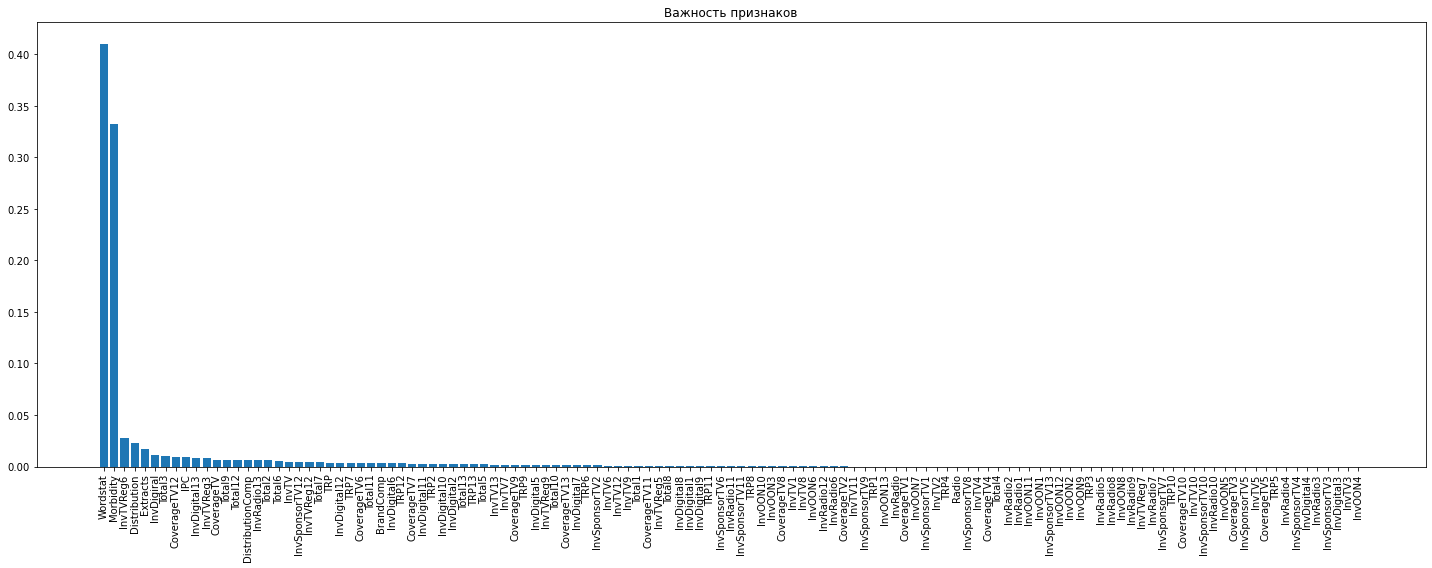

In [180]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


# Инициализируем и обучаем модель Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, Y)

import matplotlib.pyplot as plt
import numpy as np

# Получаем важности признаков и сортируем их
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализируем важность признаков
plt.figure(figsize=(20, 8))
plt.title('Важность признаков')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

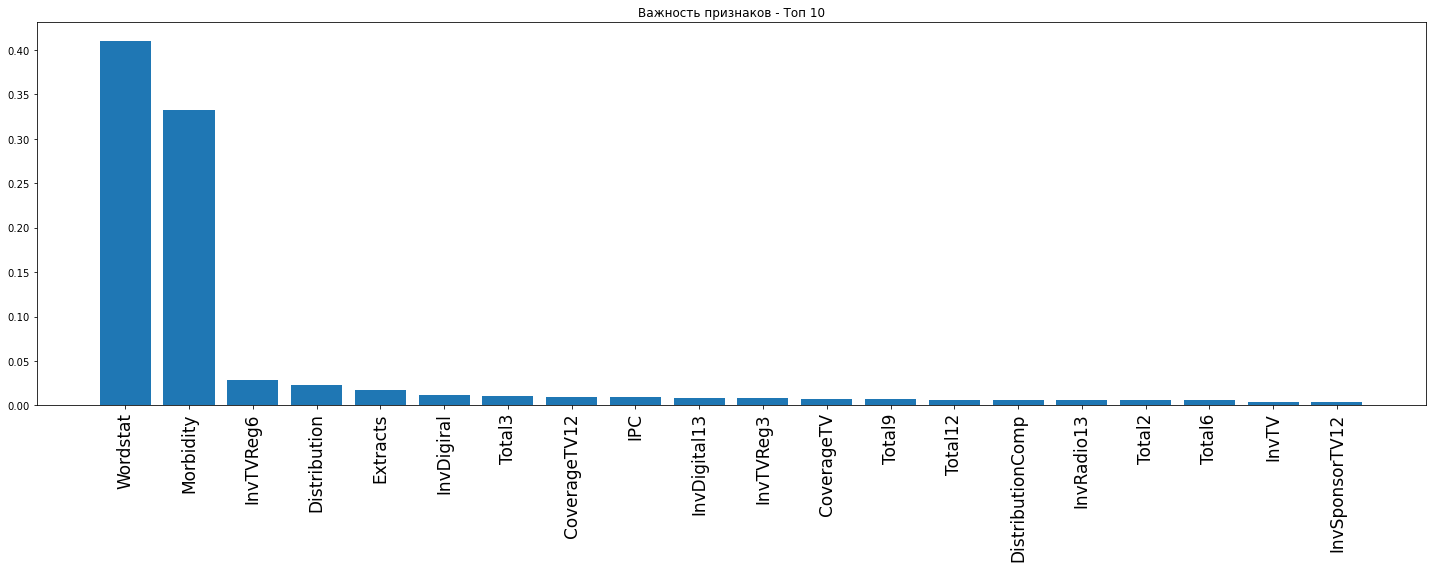

In [181]:
X_imputed = imputer.fit_transform(X)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, Y)

# Получение важностей признаков и сортировка их
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация только первых 20 наиболее важных признаков
top_20_indices = indices[:20]  # Индексы для топ-20 наиболее важных признаков
top_20_importances = importances[top_20_indices]
top_20_features = X.columns[top_20_indices]


plt.figure(figsize=(20, 8))
plt.title('Важность признаков - Топ 10')
plt.bar(range(20), top_20_importances, align='center')
plt.xticks(range(20), top_20_features, rotation=90, fontsize=17)  # Настройка размера шрифта для меток оси x
plt.tight_layout()
plt.show()

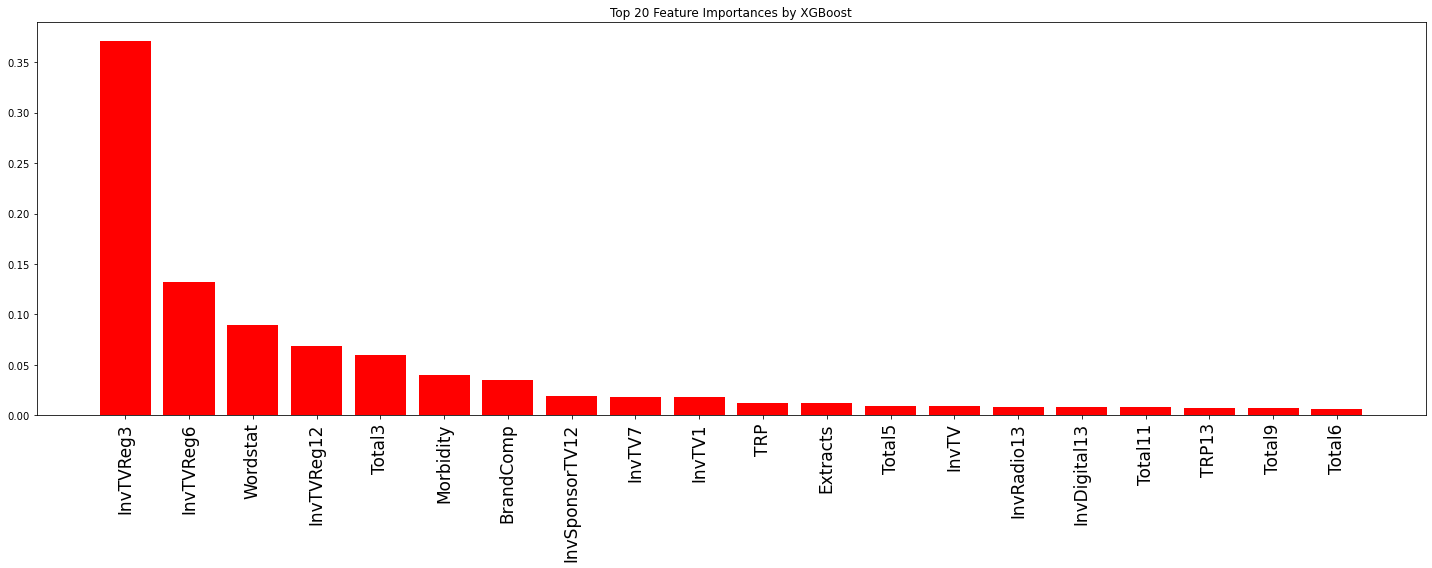

In [182]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Обучение модели XGBoost
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_imputed, Y)

# Получение и визуализация важности признаков
xgb_importances = model.feature_importances_
indices = np.argsort(xgb_importances)[::-1][:20]  # Ограничиваем первыми 20 признаками

plt.figure(figsize=(20, 8))
plt.title('Top 20 Feature Importances by XGBoost')
plt.bar(range(20), xgb_importances[indices], color='r', align='center')
plt.xticks(range(20), X.columns[indices], rotation=90, fontsize=17)
plt.tight_layout()
plt.show()

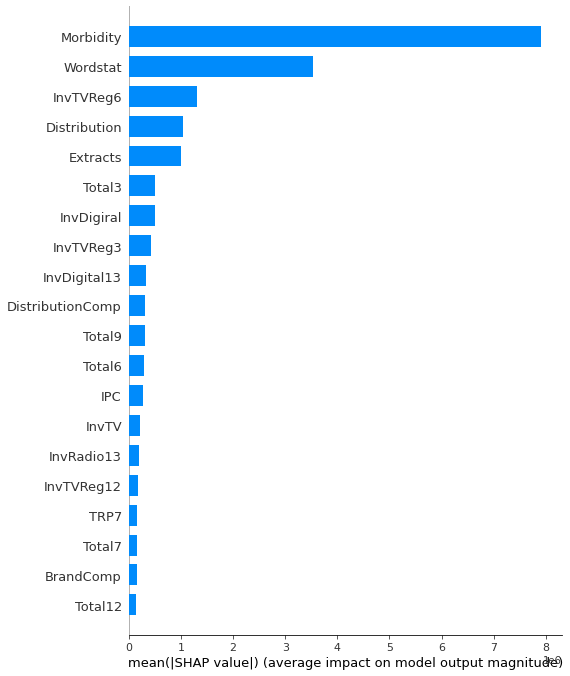

In [174]:
import shap

# Обучение модели и создание explainer объекта
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_imputed)

# Визуализация SHAP значений для топ-20 важных признаков
top_indices = np.argsort(np.abs(shap_values).mean(0))[-20:]
shap.summary_plot(shap_values[:, top_indices], X.iloc[:, top_indices], plot_type="bar")

              Feature  SHAP Importance
2           Morbidity       7907780.41
12           Wordstat       3533941.32
62          InvTVReg6       1296602.95
0        Distribution       1041241.62
1            Extracts       1001727.96
37             Total3        506481.02
9          InvDigiral        498917.50
36          InvTVReg3        414706.84
118      InvDigital13        320293.07
4    DistributionComp        316125.10
89             Total9        302184.34
63             Total6        288330.13
3                 IPC        271319.59
7               InvTV        205119.58
121        InvRadio13        199383.91
113        InvTVReg12        171919.02
64               TRP7        158342.89
72             Total7        157299.71
5           BrandComp        153063.31
114           Total12        141308.00


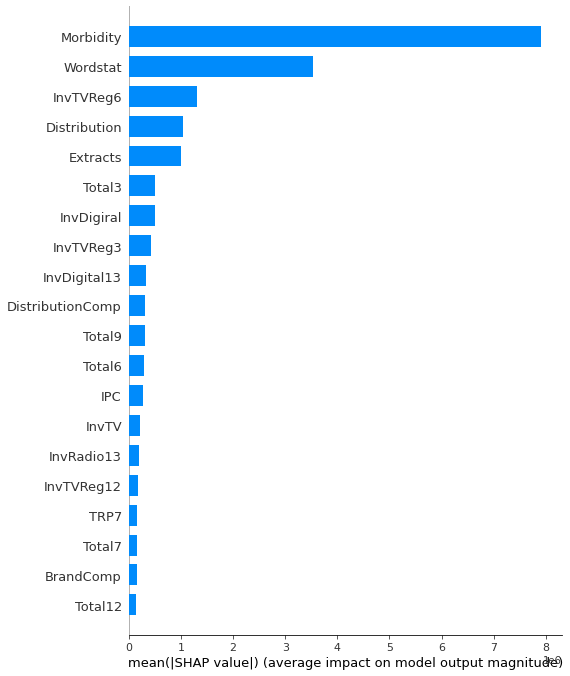

In [175]:
import shap

# Создание объекта explainer для RandomForestRegressor
explainer = shap.TreeExplainer(rf)

# Расчет SHAP значений для всех наблюдений
shap_values = explainer.shap_values(X_imputed)

# Суммирование абсолютных SHAP значений по каждому признаку для оценки общего вклада
shap_sum = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame(list(zip(X.columns, shap_sum)),
                               columns=['Feature', 'SHAP Importance'])
shap_importance.sort_values(by='SHAP Importance', ascending=False, inplace=True)

# Вывод топ-20 признаков по важности
print(shap_importance.head(20))

# Визуализация важности признаков с помощью SHAP
shap.summary_plot(shap_values, X, plot_type="bar")


In [177]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Подготовка данных для GLM
X_with_const = sm.add_constant(X_imputed)  # Добавляем константу для учета свободного члена

# Предполагаем, что Y распределена нормально, используем GLM с идентичной связующей функцией
glm_normal = sm.GLM(Y, X_with_const, family=sm.families.Gaussian()).fit()

# Предположим, что для Y лучше подходит Пуассоновское распределение
glm_poisson = sm.GLM(Y, X_with_const, family=sm.families.Poisson()).fit()

# Проверим модель с биномиальным распределением, если Y является двоичным или счетным откликом
glm_binomial = sm.GLM(Y, X_with_const, family=sm.families.Binomial()).fit()

# Вывод полных отчетов для каждой модели
print("Отчет модели GLM с нормальным распределением:\n", glm_normal.summary())
print("\nОтчет модели GLM с Пуассоновским распределением:\n", glm_poisson.summary())
print("\nОтчет модели GLM с биномиальным распределением:\n", glm_binomial.summary())


Отчет модели GLM с нормальным распределением:
                  Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      163
Model Family:                Gaussian   Df Model:                           80
Link Function:               identity   Scale:                      6.0022e+13
Method:                          IRLS   Log-Likelihood:                -4167.5
Date:                Sat, 13 Apr 2024   Deviance:                   9.7836e+15
Time:                        00:03:54   Pearson chi2:                 9.78e+15
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9991
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

invalid value encountered in log
invalid value encountered in log


In [126]:
import statsmodels.api as sm

# Линейная регрессия OLS
X_with_const = sm.add_constant(X_imputed)  # добавляем константу для учета свободного члена
model_ols = sm.OLS(Y, X_with_const).fit()

# Выводим результаты
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               SalesRub   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     21.09
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           2.07e-56
Time:                        23:38:58   Log-Likelihood:                -4167.5
No. Observations:                 244   AIC:                             8497.
Df Residuals:                     163   BIC:                             8780.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.051e+07   6.05e+07      0.999      0.3

In [127]:
from sklearn.linear_model import LassoCV

# Используем кросс-валидацию для поиска оптимального параметра регуляризации alpha
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, random_state=42)
lasso_cv.fit(X_imputed, Y)

print("Лучшее значение alpha:", lasso_cv.alpha_)
print("Коэффициенты модели Lasso с оптимальным alpha:", lasso_cv.coef_)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4285501408661492.0, tolerance: 9622883973568.078
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3847687599376093.0, tolerance: 9622883973568.078
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3656252626800819.0, tolerance: 9622883973568.078
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3411304695458052.5, tolerance: 9622883973568.078
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3232947733212765.0, tolerance: 9622883973568.078
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3208867815777358.0, tolerance: 9622883973568.078
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3204305670542003.5, tolerance: 9622883973568.078

Лучшее значение alpha: 0.01
Коэффициенты модели Lasso с оптимальным alpha: [ 2.07051941e+07 -6.31829470e+02  1.21531095e+01 -1.21943385e+07
 -6.20249866e+08  1.27093126e+06 -2.73031559e+04  1.77247503e-01
 -6.77914604e+04 -6.72667570e-02  7.18776789e-01  0.00000000e+00
  7.26018986e+02 -9.25753895e+05  1.11237730e+07  1.53815498e+01
 -5.43565460e+00 -3.87154679e+01  0.00000000e+00  0.00000000e+00
  2.14456178e-01 -9.55380525e+04  1.24442385e+06  5.98622547e+00
  8.77989867e+00  1.19797031e+01  0.00000000e+00  0.00000000e+00
 -4.59137735e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.86464154e+01  0.00000000e+00
  3.94778831e+00 -4.69709180e+00  2.87977430e+05 -7.34922268e+06
 -2.02182928e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.44657793e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.61690006e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.19849593e+01  2.43952498e+00 -6.31307307e+04
  1.29766834e+0

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3681979334255157.5, tolerance: 10473656796255.053
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3674402771428544.5, tolerance: 10473656796255.053
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3669002730069920.5, tolerance: 10473656796255.053
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3664168576369405.5, tolerance: 10473656796255.053
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3659707904503240.0, tolerance: 10473656796255.053
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3655576644163778.5, tolerance: 10473656796255.053
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3651748093290711.0, tolerance: 10473656796

In [128]:
from sklearn.linear_model import RidgeCV

# Используем кросс-валидацию для поиска оптимального параметра регуляризации alpha
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge_cv.fit(X_imputed, Y)

print("Лучшее значение alpha для Ridge:", ridge_cv.alpha_)
print("Коэффициенты модели Ridge с оптимальным alpha:", ridge_cv.coef_)

Лучшее значение alpha для Ridge: 100.0
Коэффициенты модели Ridge с оптимальным alpha: [-1.02342825e+04 -4.81475814e+02  1.04412370e+01 -3.45293619e+03
 -9.26441545e+03 -8.06060794e+05 -3.34569066e+04  2.12819900e-01
  5.09106080e+04 -2.29065934e-01  3.93921741e-01  3.67562654e-05
  7.04396510e+02 -1.30551451e+05  3.66228912e+04  1.70032323e+01
 -3.67807744e+00 -2.27298942e+01  0.00000000e+00  0.00000000e+00
 -9.40821248e+00 -4.10223162e+04  4.47461080e+03  1.00889180e+02
  1.01166895e+02  9.86121154e+01  0.00000000e+00  0.00000000e+00
 -9.64553743e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.77311337e+00  0.00000000e+00
  3.32619185e+00 -4.76967790e+00  3.16915737e+03 -1.08461230e-07
 -2.23589096e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.23683393e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.49732613e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.19966975e-01 -2.10160446e+00 -1.72121079e+04
  6.

Ill-conditioned matrix (rcond=1.47107e-17): result may not be accurate.
Ill-conditioned matrix (rcond=8.54136e-17): result may not be accurate.
Ill-conditioned matrix (rcond=6.93053e-17): result may not be accurate.
Ill-conditioned matrix (rcond=7.36422e-17): result may not be accurate.


In [129]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Подготовка данных для GLM
X_with_const = sm.add_constant(X_imputed)  # Добавляем константу для учета свободного члена

# Предполагаем, что Y распределена нормально, используем GLM с идентичной связующей функцией
glm_normal = sm.GLM(Y, X_with_const, family=sm.families.Gaussian()).fit()

# Предположим, что для Y лучше подходит Пуассоновское распределение
glm_poisson = sm.GLM(Y, X_with_const, family=sm.families.Poisson()).fit()

# Проверим модель с биномиальным распределением, если Y является двоичным или счетным откликом
glm_binomial = sm.GLM(Y, X_with_const, family=sm.families.Binomial()).fit()

# Вывод полных отчетов для каждой модели
print("Отчет модели GLM с нормальным распределением:\n", glm_normal.summary())
print("\nОтчет модели GLM с Пуассоновским распределением:\n", glm_poisson.summary())
print("\nОтчет модели GLM с биномиальным распределением:\n", glm_binomial.summary())


Отчет модели GLM с нормальным распределением:
                  Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      163
Model Family:                Gaussian   Df Model:                           80
Link Function:               identity   Scale:                      6.0022e+13
Method:                          IRLS   Log-Likelihood:                -4167.5
Date:                Fri, 12 Apr 2024   Deviance:                   9.7836e+15
Time:                        23:46:22   Pearson chi2:                 9.78e+15
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9991
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

invalid value encountered in log
invalid value encountered in log


In [130]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Создаем RandomForestRegressor и обучаем его
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, Y)

# Создаем explainer и вычисляем SHAP значения
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_imputed)

# Сортируем признаки по важности
shap_importance = pd.DataFrame(list(zip(X.columns, np.abs(shap_values).mean(0))),
                               columns=['Feature', 'SHAP Importance'])
shap_importance.sort_values(by='SHAP Importance', ascending=False, inplace=True)

# Выбираем топ-20 признаков
top_features = shap_importance.head(20)['Feature'].values

# Фильтруем 'X_imputed' для использования только топ-20 признаков
top_indices = [list(X.columns).index(feature) for feature in top_features]
X_top_imputed = X_imputed[:, top_indices]

# Добавляем константу к отфильтрованным признакам
X_top_with_const = sm.add_constant(X_top_imputed)

# Построение GLM
glm = sm.GLM(Y, X_top_with_const, family=sm.families.Gaussian()).fit()
print(glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      223
Model Family:                Gaussian   Df Model:                           20
Link Function:               identity   Scale:                      1.1486e+14
Method:                          IRLS   Log-Likelihood:                -4285.0
Date:                Fri, 12 Apr 2024   Deviance:                   2.5613e+16
Time:                        23:51:46   Pearson chi2:                 2.56e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9527
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.057e+08   5.91e+07      1.789      0.0

In [132]:
X_imputed

array([[9.21069767e-01, 9.96985954e+04, 5.08956000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 9.08552801e+06],
       [9.21069767e-01, 9.96985954e+04, 8.04825000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 1.05997827e+07],
       [9.21069767e-01, 9.96985954e+04, 9.93384000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 1.05997827e+07],
       ...,
       [9.97500000e-01, 6.44085842e+04, 3.98580000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.97500000e-01, 6.44085842e+04, 4.29240000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.97500000e-01, 6.44085842e+04, 4.59900000e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [131]:
import statsmodels.api as sm

# Преобразуем X_imputed обратно в DataFrame с правильными именами колонок
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Теперь мы можем добавить константу непосредственно к DataFrame
X_with_const = sm.add_constant(X_imputed_df)

# Теперь выбираем только топ-20 признаков на основе SHAP значений
top_features = shap_importance.head(20)['Feature']
X_top_features = X_with_const[top_features]

# Построение GLM с топ-20 признаками
glm = sm.GLM(Y, X_top_features, family=sm.families.Gaussian()).fit()

# Вывод результатов с названиями переменных
print(glm.summary())

ValueError: The indices for endog and exog are not aligned

In [184]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import shap

# Предположим, что media_wise_filtered уже загружен и содержит все необходимые данные
# Определение столбцов для удаления
columns_to_drop = ['SalesRub', 'year', 'week', 'weekB', 'Sales', 'SalesRubMonth', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6']
X = media_wise_filtered.drop(columns=columns_to_drop, errors='ignore')
Y = media_wise_filtered['SalesRub'].dropna()

# Исправление нечисловых данных и заполнение пропусков
X = X.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Обучение RandomForest для вычисления SHAP значений
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_imputed, Y)

# Создание SHAP explainer и получение значений
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_imputed)

# Сортировка признаков по важности SHAP и выбор топ-20
shap_importance = pd.DataFrame(list(zip(X.columns, np.abs(shap_values).mean(0))),
                               columns=['Feature', 'SHAP Importance'])
shap_importance.sort_values(by='SHAP Importance', ascending=False, inplace=True)
top_features = shap_importance.head(20)['Feature'].values

# Фильтрация X для использования только топ-20 признаков
X_top = X_imputed[top_features]

# Добавление константы для учета свободного члена в модели
X_top_with_const = sm.add_constant(X_top)

# Построение и обучение GLM
glm = sm.GLM(Y, X_top_with_const, family=sm.families.Gaussian()).fit()

# Вывод результатов
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      223
Model Family:                Gaussian   Df Model:                           20
Link Function:               identity   Scale:                      1.1486e+14
Method:                          IRLS   Log-Likelihood:                -4285.0
Date:                Sat, 13 Apr 2024   Deviance:                   2.5613e+16
Time:                        00:08:58   Pearson chi2:                 2.56e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9527
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.057e+08   5.91e+07  

In [187]:
# Фильтрация X для использования только топ-20 признаков
X_top = X_imputed[top_features]

# Добавление константы для учета свободного члена в модели
X_top_with_const = sm.add_constant(X_top)

# Построение и первоначальное обучение GLM
initial_glm = sm.GLM(Y, X_top_with_const, family=sm.families.Gaussian()).fit()

# Фильтрация признаков на основе p-значений
results_summary = initial_glm.summary2().tables[1]
significant_features = results_summary[results_summary['P>|z|'] <= 0.05].index.tolist()

# Повторное использование только значимых признаков
X_significant = X_top_with_const[significant_features]

# Построение и обучение улучшенной GLM
glm_improved = sm.GLM(Y, X_significant, family=sm.families.Gaussian()).fit()

# Вывод результатов улучшенной модели
print(glm_improved.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               SalesRub   No. Observations:                  244
Model:                            GLM   Df Residuals:                      236
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                      1.2799e+14
Method:                          IRLS   Log-Likelihood:                -4305.1
Date:                Sat, 13 Apr 2024   Deviance:                   3.0205e+16
Time:                        00:17:51   Pearson chi2:                 3.02e+16
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9249
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Wordstat     955.0632     37.672     25.352      0.0

In [188]:
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.impute import SimpleImputer

# Подготовка данных
X = media_wise_filtered.drop(columns=columns_to_drop, errors='ignore').select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X = X.clip(lower=0.01)  # Заменяем нули и отрицательные значения на 0.01

# Теперь безопасно применяем логарифм
X_logged = np.log(X)


# Проверка стационарности каждой переменной
def check_stationarity(data, threshold=0.05):
    p_values = {}
    for column in data.columns:
        p_value = adfuller(data[column])[1]  # p-value from the ADF test
        p_values[column] = p_value
    return {k: v for k, v in p_values.items() if v < threshold}

stationary_variables = check_stationarity(X_imputed)
X_stationary = X_imputed[stationary_variables.keys()]

# Генерация всех возможных комбинаций признаков
all_combinations = sum([list(combinations(X_stationary.columns, i)) for i in range(1, len(X_stationary.columns) + 1)], [])

# Словарь для сохранения AIC каждой модели
aic_values = {}

# Построение моделей VAR для каждой комбинации
for combo in all_combinations:
    model = VAR(X_stationary[list(combo)])
    results = model.fit(maxlags=15, ic='aic')
    aic_values[combo] = results.aic

# Выбор 10 комбинаций с наименьшим AIC
best_combinations = sorted(aic_values, key=aic_values.get)[:10]

# Вывод лучших комбинаций и их AIC
for combo in best_combinations:
    print(f"Combination: {combo}, AIC: {aic_values[combo]}")


divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero

MemoryError: 

In [189]:
from itertools import combinations

# Генерация комбинаций с ограничением до 5 признаков
max_features_in_combination = 7
all_combinations = sum([list(combinations(X_stationary.columns, i)) for i in range(1, max_features_in_combination + 1)], [])

# Словарь для сохранения AIC каждой модели
aic_values = {}

# Построение моделей VAR для каждой комбинации и вычисление AIC
for combo in all_combinations:
    model = VAR(X_stationary[list(combo)])
    try:
        results = model.fit(maxlags=15, ic='aic')
        aic_values[combo] = results.aic
    except Exception as e:
        aic_values[combo] = np.inf  # Назначаем бесконечность для моделей, которые не могут быть построены

# Выбор 10 комбинаций с наименьшим AIC
best_combinations = sorted(aic_values, key=aic_values.get)[:10]

# Вывод лучших комбинаций и их AIC
for combo in best_combinations:
    print(f"Combination: {combo}, AIC: {aic_values[combo]}")


MemoryError: 

In [190]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
import pandas as pd

# Предполагаем, что Y загружен и представляет собой временной ряд целевой переменной
Y = media_wise_filtered['SalesRub'].dropna()

# Разделение данных на обучающую и тестовую выборки
n_forecast = 28  # Количество периодов для прогнозирования
train, test = model_selection.train_test_split(Y, test_size=n_forecast)

# Подбор модели ARIMA
auto_model = pm.auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True,
                           information_criterion='aic',  # Выбор модели по AIC
                           out_of_sample_size=n_forecast)  # Количество данных для тестирования "out of sample"

# Вывод лучших параметров
print("Выбранные параметры модели ARIMA (p,d,q) и (P,D,Q,m):")
print(f"    ARIMA{auto_model.order}x{auto_model.seasonal_order}")

# Обучение выбранной модели на полных данных
model_fit = auto_model.fit(Y)

# Прогнозирование
forecast = model_fit.predict(n_periods=n_forecast)

# Вывод прогноза
print("Прогноз на следующие 28 периодов:")
print(forecast)

# Оценка прогноза
r2 = r2_score(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print(f"R²: {r2}")
print(f"MAPE: {mape}")


ModuleNotFoundError: No module named 'pmdarima'

In [191]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/a3/94/af13b58081670aa16a82ff6b062032d50994cae87cc806c40f1c9c97a5e1/pmdarima-2.0.4-cp38-cp38-win_amd64.whl.metadata


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 615.5/615.5 kB 2.3 MB/s eta 0:00:00


In [194]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Предполагаем, что Y загружен и представляет собой временной ряд целевой переменной
Y = media_wise_filtered['SalesRub'].dropna()

# Разделение данных на обучающую и тестовую выборки
n_forecast = 28  # Количество периодов для прогнозирования
train, test = model_selection.train_test_split(Y, test_size=n_forecast)

# Подбор модели ARIMA
auto_model = pm.auto_arima(train, seasonal=True, m=12, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True,
                           information_criterion='aic',  # Выбор модели по AIC
                           out_of_sample_size=n_forecast)  # Количество данных для тестирования "out of sample"

# Вывод лучших параметров
print("Выбранные параметры модели ARIMA (p,d,q) и (P,D,Q,m):")
print(f"    ARIMA{auto_model.order}x{auto_model.seasonal_order}")

# Обучение выбранной модели на полных данных
model_fit = auto_model.fit(Y)

# Прогнозирование
forecast = model_fit.predict(n_periods=n_forecast)

# Вывод прогноза
print("Прогноз на следующие 28 периодов:")
print(forecast)

# Оценка прогноза
r2 = r2_score(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print(f"R²: {r2}")
print(f"MAPE: {mape}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7651.857, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7637.989, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7634.220, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7649.779, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7632.359, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7634.230, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=7636.099, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7633.977, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=7634.286, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7636.075, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=7630.363, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=7632.235, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12]     

In [196]:
import numpy as np

def prepare_lstm_data(data, history_length=60, forecast_horizon=28):
    X, Y = [], []
    for i in range(len(media_wise_filtered) - history_length - forecast_horizon + 1):
        X.append(media_wise_filtered[i:i+history_length])
        Y.append(media_wise_filtered[i+history_length:i+history_length+forecast_horizon])
    return np.array(X), np.array(Y)

# Пример использования
history_length = 60
forecast_horizon = 28
X_lstm, Y_lstm = prepare_lstm_data(data.values, history_length, forecast_horizon)
print("Форма X_lstm:", X_lstm.shape)
print("Форма Y_lstm:", Y_lstm.shape)


NameError: name 'data' is not defined